In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [2]:
clean_df = pd.read_csv('AmesHousing.csv', sep='\t')
print(clean_df.head())

   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0       

In [3]:
print(clean_df.shape)

(2930, 82)


In [4]:
print(clean_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [5]:
# duplicates check
clean_df.duplicated().sum()

np.int64(0)

In [6]:
# check number of numerical vs cathegorical features
clean_df.dtypes.value_counts()
# => all treated as cathegorical, even though some should'nt

,count
object,43
int64,28
float64,11


43 out of the 82 fetures are cathegorical, so for the next steps we will work on converting them to numerical

In [7]:
# check number of missing values per feature
missing = clean_df.isnull().sum().sort_values(ascending=False).head(30)
print(missing)


Pool QC           2917
Misc Feature      2824
Alley             2732
Fence             2358
Mas Vnr Type      1775
Fireplace Qu      1422
Lot Frontage       490
Garage Qual        159
Garage Yr Blt      159
Garage Cond        159
Garage Finish      159
Garage Type        157
Bsmt Exposure       83
BsmtFin Type 2      81
Bsmt Qual           80
Bsmt Cond           80
BsmtFin Type 1      80
Mas Vnr Area        23
Bsmt Full Bath       2
Bsmt Half Bath       2
Total Bsmt SF        1
BsmtFin SF 1         1
BsmtFin SF 2         1
Garage Area          1
Garage Cars          1
Bsmt Unf SF          1
Electrical           1
Lot Shape            0
Street               0
Lot Area             0
dtype: int64


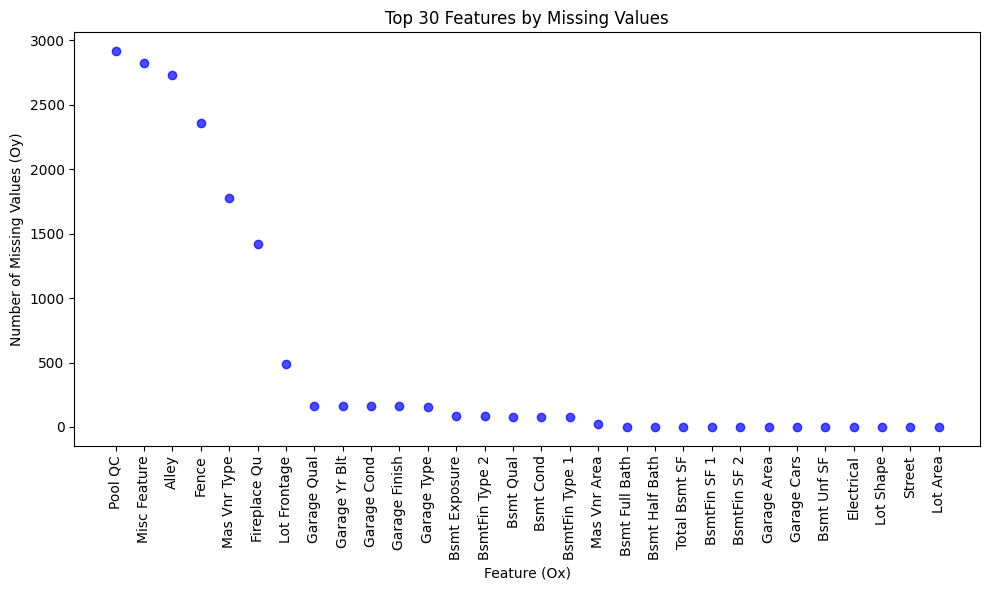

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(missing.index, missing.values, color='blue', alpha=0.7)

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel("Feature (Ox)")
plt.ylabel("Number of Missing Values (Oy)")
plt.title("Top 30 Features by Missing Values")

# Make layout tidy and show plot
plt.tight_layout()
plt.show()

The plot shows the features that have a high amount of missing values.

In [9]:
pool_sizes = clean_df['Pool Area'].sort_values(ascending=False).head(13)
print(pool_sizes)

no_pool = (clean_df['Pool Area'] == 0).sum()
print(no_pool)
print("Percentage of houses without a pool: {:.2f}%".format((no_pool / len(clean_df)) * 100))

2498    800
2735    738
2357    648
1566    576
2278    561
1760    555
2350    519
2570    512
1498    480
2089    444
1940    368
2230    228
1063    144
Name: Pool Area, dtype: int64
2917
Percentage of houses without a pool: 99.56%


Based on the quant analysis we decided to drop the 2 columns regarding the pool, instead replaced them with hasPool: 0 if has not, 1 if has

In [10]:
df_noPool = clean_df.copy(deep=True)
df_noPool['hasPool'] = (clean_df['Pool Area'] > 0).astype(int)
df_noPool.drop(['Pool Area', 'Pool QC'], axis=1, inplace=True)
print(df_noPool['hasPool'].value_counts())

hasPool
0    2917
1      13
Name: count, dtype: int64


In [11]:
no_fireplace = (clean_df['Fireplaces'] == 0).sum()
print(no_fireplace)
print("Percentage of houses without a fireplace: {:.2f}%".format((no_fireplace / len(clean_df)) * 100))


1422
Percentage of houses without a fireplace: 48.53%


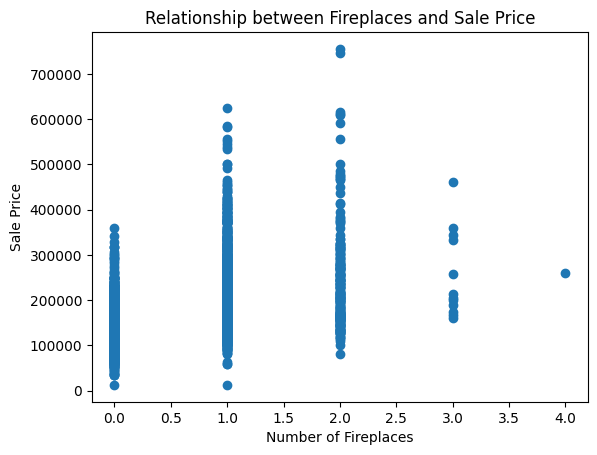

In [12]:
plt.scatter(clean_df['Fireplaces'], clean_df['SalePrice'])
plt.xlabel('Number of Fireplaces')
plt.ylabel('Sale Price')
plt.title('Relationship between Fireplaces and Sale Price')
plt.show()

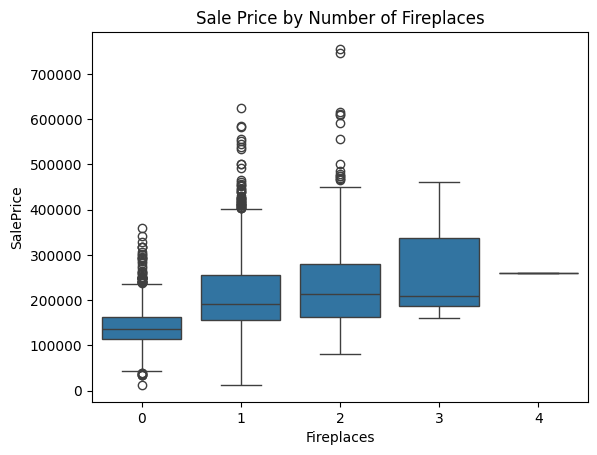

In [13]:
sns.boxplot(x='Fireplaces', y='SalePrice', data=clean_df)
plt.title('Sale Price by Number of Fireplaces')
plt.show()

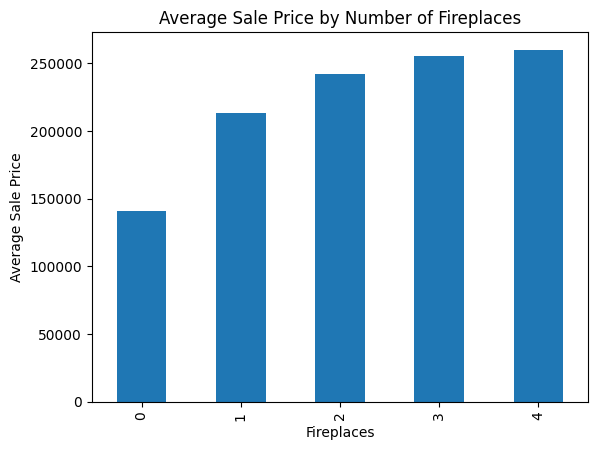

In [14]:
"Bar plot of mean sale price per fireplace count"
clean_df.groupby('Fireplaces')['SalePrice'].mean().plot(kind='bar')
plt.ylabel('Average Sale Price')
plt.title('Average Sale Price by Number of Fireplaces')
plt.show()

Given by the above plots there seems to be a direct corelation between how many fireplaces a house has and its price, and the quant analysis shows that the fireplace column is populated plenty.

In [15]:
print("Fireplace Quality value counts, for existing values:")
print(clean_df['Fireplace Qu'].value_counts())
print("Number of missing values in 'Fireplace Qu':")
print(clean_df['Fireplace Qu'].isna().sum())
print("Percentage of missing values in 'Fireplace Qu': {:.2f}%".format((clean_df['Fireplace Qu'].isna().sum() / len(clean_df)) * 100))

Fireplace Quality value counts, for existing values:
Fireplace Qu
Gd    744
TA    600
Fa     75
Po     46
Ex     43
Name: count, dtype: int64
Number of missing values in 'Fireplace Qu':
1422
Percentage of missing values in 'Fireplace Qu': 48.53%


This is the same percentage as the houses that have no fireplace, so we cant ignore this column based only on the non existing values, we need to test how the Qu column affects the price.

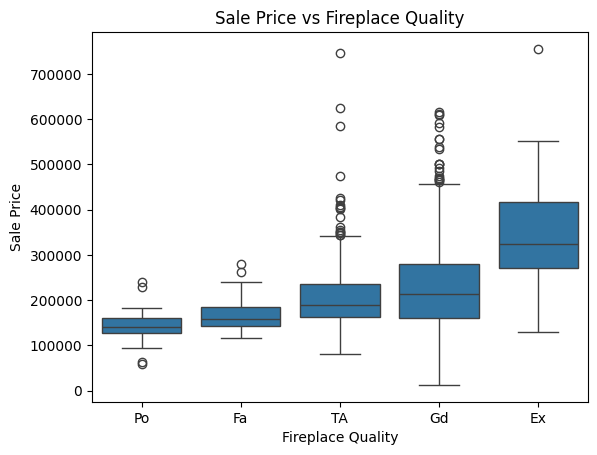

In [16]:
order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
sns.boxplot(x='Fireplace Qu', y='SalePrice', data=clean_df, order=order)
plt.xlabel('Fireplace Quality')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Fireplace Quality')
plt.show()

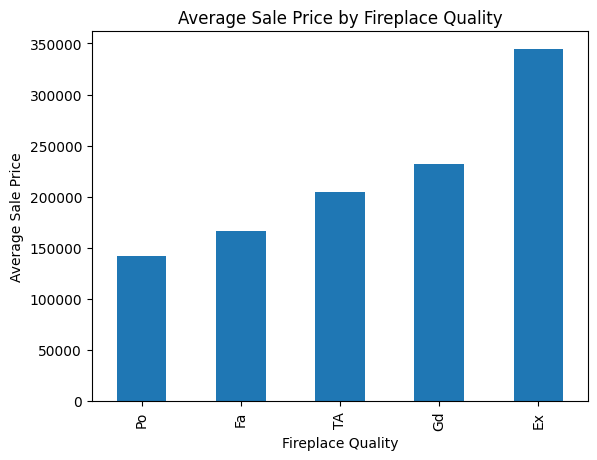

In [17]:
clean_df.groupby('Fireplace Qu')['SalePrice'].mean().reindex(order).plot(kind='bar')
plt.xlabel('Fireplace Quality')
plt.ylabel('Average Sale Price')
plt.title('Average Sale Price by Fireplace Quality')
plt.show()

Shown by the above 2 plots the quality of the fireplace is meaningfull, so the next logical step would be to split the feature into features of numerical values with one hot encoding. We will use the df_noPool copy to first replace the NaN valuse with "None" for the Qu feature, the apply one hot encoding.

In [18]:
# Fill missing Fireplace Quality with "None"
df_noPool['Fireplace Qu'] = df_noPool['Fireplace Qu'].fillna('None')

In [19]:
# One-hot encode the Fireplace Quality column
df_noPool = pd.get_dummies(df_noPool, columns=['Fireplace Qu'], prefix='FireplaceQu', dtype=int)

print(df_noPool.filter(like='FireplaceQu_').head())

   FireplaceQu_Ex  FireplaceQu_Fa  FireplaceQu_Gd  FireplaceQu_None  \
0               0               0               1                 0   
1               0               0               0                 1   
2               0               0               0                 1   
3               0               0               0                 0   
4               0               0               0                 0   

   FireplaceQu_Po  FireplaceQu_TA  
0               0               0  
1               0               0  
2               0               0  
3               0               1  
4               0               1  


[[ keep in mind possibility for another feature: "fireplace score like: quality * number of fireplaces"]]

we are also dropping the 'Order' and 'PID' columns from our copy df as they are meaningless

In [20]:
df_copy = df_noPool.drop(['Order', 'PID'], axis=1)
print(df_copy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 84 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MS SubClass       2930 non-null   int64  
 1   MS Zoning         2930 non-null   object 
 2   Lot Frontage      2440 non-null   float64
 3   Lot Area          2930 non-null   int64  
 4   Street            2930 non-null   object 
 5   Alley             198 non-null    object 
 6   Lot Shape         2930 non-null   object 
 7   Land Contour      2930 non-null   object 
 8   Utilities         2930 non-null   object 
 9   Lot Config        2930 non-null   object 
 10  Land Slope        2930 non-null   object 
 11  Neighborhood      2930 non-null   object 
 12  Condition 1       2930 non-null   object 
 13  Condition 2       2930 non-null   object 
 14  Bldg Type         2930 non-null   object 
 15  House Style       2930 non-null   object 
 16  Overall Qual      2930 non-null   int64  


Next we are observing the alley and street features.

In [21]:
alley = clean_df['Alley'].value_counts(dropna=False)
print(alley)

Alley
NaN     2732
Grvl     120
Pave      78
Name: count, dtype: int64


In [22]:
street = clean_df['Street'].value_counts(dropna=False)
print(street)

Street
Pave    2918
Grvl      12
Name: count, dtype: int64


The alley feature is sparsly populated so we decided to remove it completly from our copy.

In [23]:
df_copy = df_copy.drop(['Alley'], axis=1)

In [24]:
# Cheking the relevance of the street feature
clean_df.groupby('Street')['SalePrice'].mean()

,SalePrice
Street,
Grvl,106663.333333
Pave,181100.923920


<Axes: xlabel='Street', ylabel='SalePrice'>

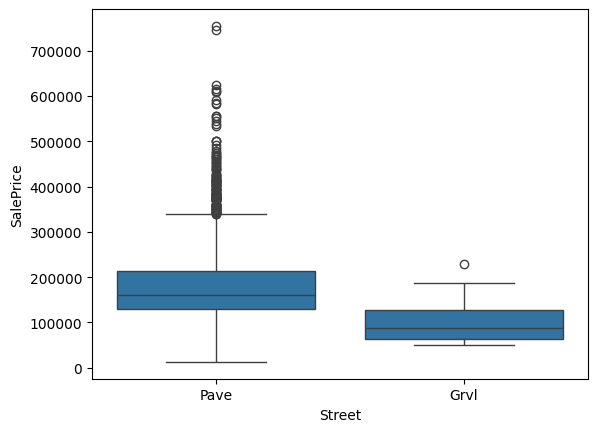

In [25]:
sns.boxplot(x='Street', y='SalePrice', data=clean_df)

To keep the data that points to gravel we will replace our Street feature with a Paved_Street feature that has 1 for paved and 0 for gravel, we are losing no information by doing this because all houses are linked to a street of one of the two types.

In [26]:
df_copy['Paved_Street'] = (df_copy['Street'] == 'Pave').astype(int)

In [27]:
df_copy.drop('Street', axis=1, inplace=True)

In [28]:
# check number of missing values per feature in our modified dataframe
missing = df_copy.isnull().sum().sort_values(ascending=False).head(10)
print(missing)

Misc Feature     2824
Fence            2358
Mas Vnr Type     1775
Lot Frontage      490
Garage Finish     159
Garage Cond       159
Garage Yr Blt     159
Garage Qual       159
Garage Type       157
Bsmt Exposure      83
dtype: int64


Next we will keep our focus on the 3 most unpopulated features, starting with Misc Feature(cupled with Misc Val).

In [29]:
print(clean_df[['Misc Feature', 'Misc Val']].head(10))

  Misc Feature  Misc Val
0          NaN         0
1          NaN         0
2         Gar2     12500
3          NaN         0
4          NaN         0
5          NaN         0
6          NaN         0
7          NaN         0
8          NaN         0
9          NaN         0


In [30]:
print(clean_df['Misc Feature'].value_counts(dropna=False))

Misc Feature
NaN     2824
Shed      95
Gar2       5
Othr       4
Elev       1
TenC       1
Name: count, dtype: int64


We will test if there is a significant price difference in houses that have Misc Features.

In [31]:
clean_df.groupby(clean_df['Misc Val'] > 0)['SalePrice'].mean()

,SalePrice
Misc Val,
False,181751.077821
True,154584.067961


The feature seems to have a negative corelation with the sale price(perhaps: "houses with sheds are cheaper" and so the price of the 1 house with an elevator does not bring up the average enough). Based on the analysis keeping either one of the features is not meaningfull, they add noise to our data.

In [32]:
df_copy.drop(['Misc Feature', 'Misc Val'], axis=1, inplace=True)

Next we will observe the Fence feature.

In [33]:
print(clean_df['Fence'].value_counts(dropna=False))

Fence
NaN      2358
MnPrv     330
GdPrv     118
GdWo      112
MnWw       12
Name: count, dtype: int64


In [34]:
clean_df.groupby('Fence')['SalePrice'].mean().sort_values(ascending=False)

,SalePrice
Fence,
GdPrv,176465.915254
MnPrv,146189.984848
GdWo,141993.508929
MnWw,133720.833333


<Axes: xlabel='Fence', ylabel='SalePrice'>

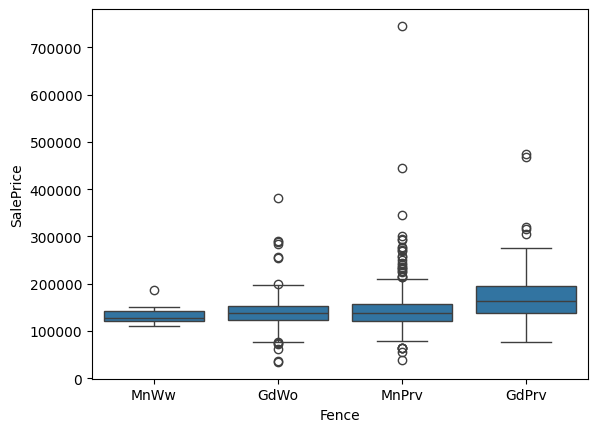

In [35]:
order = ['MnWw', 'GdWo', 'MnPrv', 'GdPrv']

sns.boxplot(x='Fence', y='SalePrice', data=clean_df, order=order)

There is some concern about the validity of the terms for this feature but for simplicitys sake we will go on with: GdPrv > MnPrv > GdWo > MnWw > NoFence. Because of the proportional relation of fence type to house price we will have fence as a ordinal numerical feature and encode it as such.

In [36]:
fence_mapping = {
    'GdPrv': 4,
    'MnPrv': 3,
    'GdWo': 2,
    'MnWw': 1,
    np.nan: 0  # No fence
}
df_copy['Fence_Quality'] = df_copy['Fence'].map(fence_mapping)
df_copy.drop('Fence', axis=1, inplace=True)

In [37]:
print(df_copy['Fence_Quality'].value_counts(dropna=False))

Fence_Quality
0    2358
3     330
4     118
2     112
1      12
Name: count, dtype: int64


Moving on with the last sparsly populated column: Mas Vnr Type

In [38]:
print(clean_df['Mas Vnr Type'].value_counts(dropna=False))

Mas Vnr Type
NaN        1775
BrkFace     880
Stone       249
BrkCmn       25
CBlock        1
Name: count, dtype: int64


Because CBlock has only one entry we can safely remove that whole row from our copy df.

In [39]:
df_copy = df_copy[df_copy['Mas Vnr Type'] != 'CBlock']

In [40]:
print(df_copy['Mas Vnr Type'].value_counts(dropna=False))

Mas Vnr Type
NaN        1775
BrkFace     880
Stone       249
BrkCmn       25
Name: count, dtype: int64


In [41]:
clean_df.groupby('Mas Vnr Type')['SalePrice'].mean().sort_values(ascending=False)

,SalePrice
Mas Vnr Type,
Stone,260547.297189
BrkFace,210798.592045
BrkCmn,140199.000000
CBlock,80000.000000


Based on the average prices for each type our order will be: Stone>BrkFace>BrkCmn>Cblock>None

<Axes: xlabel='Mas Vnr Type', ylabel='SalePrice'>

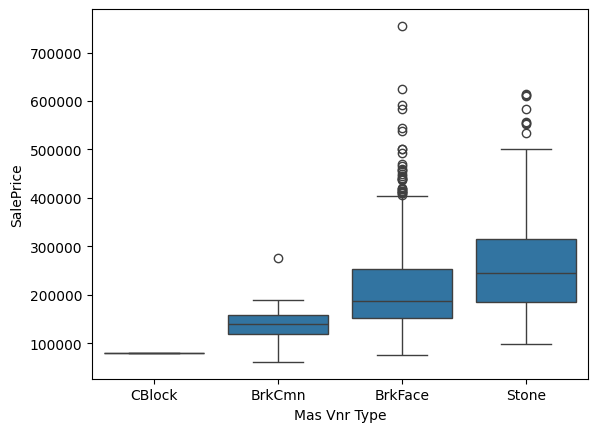

In [42]:
order = ['CBlock', 'BrkCmn', 'BrkFace', 'Stone']

sns.boxplot(x='Mas Vnr Type', y='SalePrice', data=clean_df, order=order)

This feature also corelates with Mas Vnr Area.

In [43]:
clean_df.loc[clean_df['Mas Vnr Area'].isna(), ['Mas Vnr Area', 'Mas Vnr Type']]
# we can suppose that these rows have missing info

,Mas Vnr Area,Mas Vnr Type
55,NaN,NaN
484,NaN,NaN
517,NaN,NaN
538,NaN,NaN
867,NaN,NaN
1095,NaN,NaN
1119,NaN,NaN
1122,NaN,NaN
1127,NaN,NaN
1184,NaN,NaN


In [44]:
masonry_mapping = {
    'BrkCmn': 1,
    'BrkFace': 2,
    'Stone': 3,
    np.nan: 0
}
df_copy['MasVnr_Quality'] = df_copy['Mas Vnr Type'].map(masonry_mapping)
df_copy['Mas Vnr Area'] = df_copy['Mas Vnr Area'].fillna(0)
df_copy.drop('Mas Vnr Type', axis=1, inplace=True)

We mapped the concrete values to numerical values and replaced missing values with 0 for both features.

In [45]:
missing = df_copy.isnull().sum().sort_values(ascending=False).head(10)
print(missing)

Lot Frontage      490
Garage Finish     159
Garage Yr Blt     159
Garage Cond       159
Garage Qual       159
Garage Type       157
Bsmt Exposure      83
BsmtFin Type 2     81
Bsmt Qual          80
Bsmt Cond          80
dtype: int64


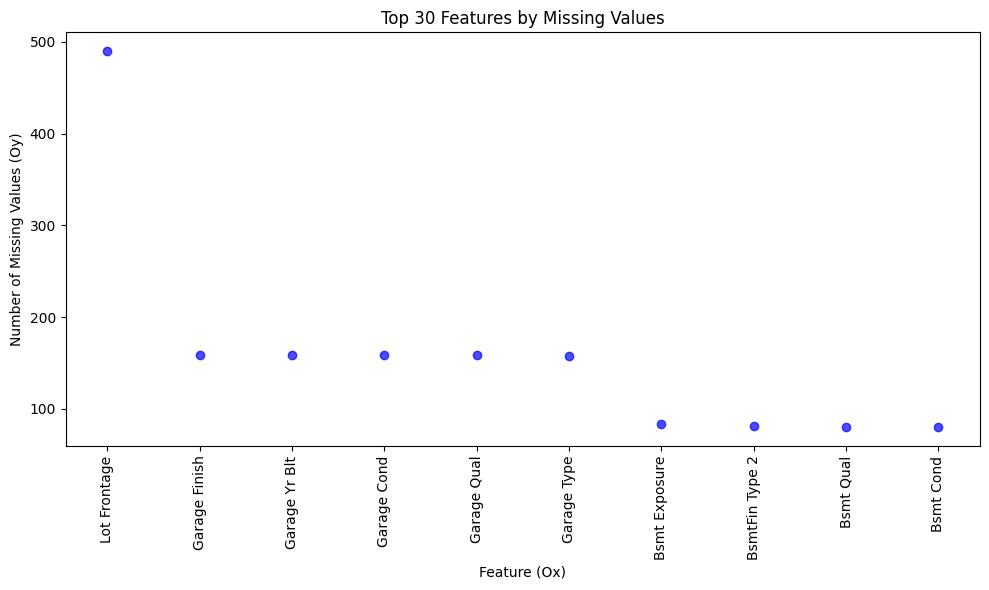

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(missing.index, missing.values, color='blue', alpha=0.7)

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel("Feature (Ox)")
plt.ylabel("Number of Missing Values (Oy)")
plt.title("Top 30 Features by Missing Values")

# Make layout tidy and show plot
plt.tight_layout()
plt.show()

Next we will tackle the features with a median amount of missing values, starting with Lot frontage.

In [47]:
print(clean_df[['Lot Frontage', 'Lot Area']].head(10))

   Lot Frontage  Lot Area
0         141.0     31770
1          80.0     11622
2          81.0     14267
3          93.0     11160
4          74.0     13830
5          78.0      9978
6          41.0      4920
7          43.0      5005
8          39.0      5389
9          60.0      7500


In [48]:
print(clean_df['Lot Frontage'].value_counts())
print("Number of missing values for 'Lot Frontage':")
print(clean_df['Lot Frontage'].isna().sum())
print("Number of missing values for 'Lot Area':")
print(clean_df['Lot Area'].isna().sum())

Lot Frontage
60.0     276
80.0     137
70.0     133
50.0     117
75.0     105
        ... 
168.0      1
111.0      1
131.0      1
153.0      1
133.0      1
Name: count, Length: 128, dtype: int64
Number of missing values for 'Lot Frontage':
490
Number of missing values for 'Lot Area':
0


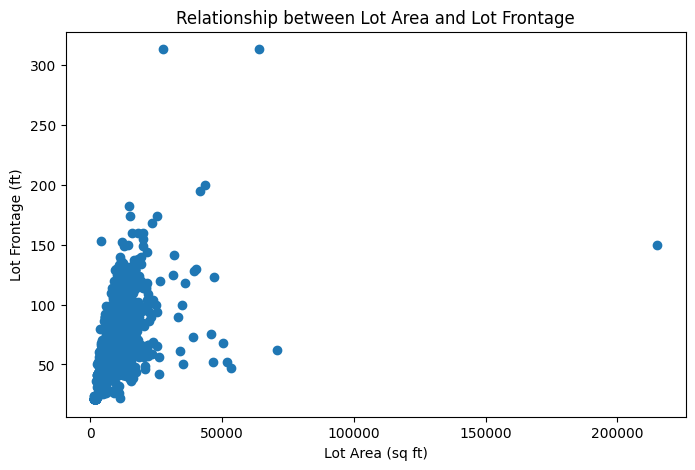

In [49]:
frontage_data = df_copy[df_copy['Lot Frontage'].notna()]
plt.figure(figsize=(8,5))
plt.scatter(frontage_data['Lot Area'], frontage_data['Lot Frontage'])
plt.xlabel('Lot Area (sq ft)')
plt.ylabel('Lot Frontage (ft)')
plt.title('Relationship between Lot Area and Lot Frontage')
plt.show()

In [50]:
corr = frontage_data['Lot Area'].corr(frontage_data['Lot Frontage'])
print(f"Correlation between Lot Area and Lot Frontage: {corr:.3f}")

Correlation between Lot Area and Lot Frontage: 0.490


r ≈ 0.7–0.9 → strong linear relationship (good for regression-based imputation)

r ≈ 0.4–0.6 → moderate correlation

r < 0.3 → weak relationship (you’ll need neighborhood-based imputation instead)

Our value is not conclusive so we will widen our approuch to include the Neighbourhood feature.

In [51]:
clean_df[['Neighborhood', 'Lot Frontage']].groupby('Neighborhood').median().sort_values(by='Lot Frontage')


,Lot Frontage
Neighborhood,
BrDale,21.0
MeadowV,21.0
NPkVill,24.0
Blueste,24.0
Greens,40.0
Blmngtn,43.0
BrkSide,51.0
IDOTRR,60.0
OldTown,60.0


We will be filling our missing values with the median for each neighbourhood, for the last 2 we will use the overall median.

In [52]:
overall_median = df_copy['Lot Frontage'].median()

df_copy['Lot Frontage'] = df_copy.groupby('Neighborhood')['Lot Frontage'].transform(
    lambda x: x.fillna(x.median() if not np.isnan(x.median()) else overall_median)
)

In [53]:
print(df_copy['Lot Frontage'].isna().sum())

0


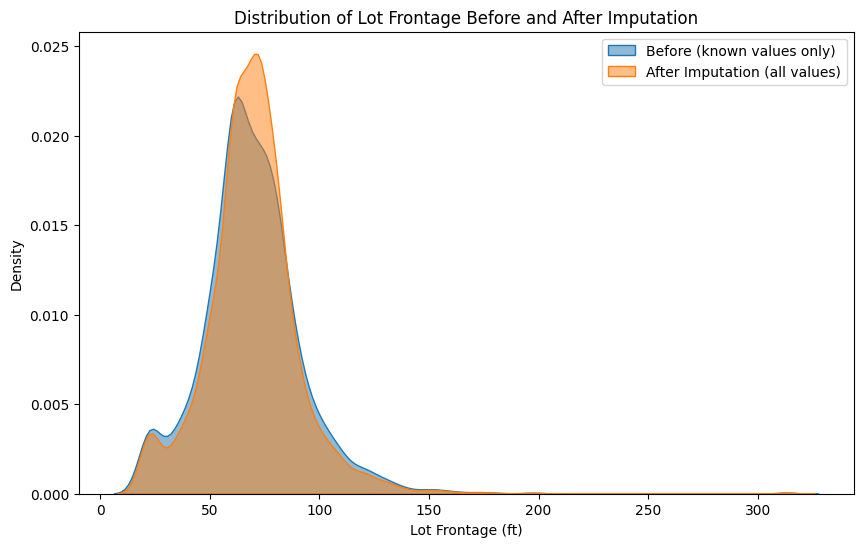

In [54]:
lot_frontage_before = clean_df['Lot Frontage'].copy()

plt.figure(figsize=(10,6))

# Plot known values (before)
sns.kdeplot(lot_frontage_before.dropna(), label='Before (known values only)', fill=True, alpha=0.5)

# Plot after imputation (all values)
sns.kdeplot(df_copy['Lot Frontage'], label='After Imputation (all values)', fill=True, alpha=0.5)

plt.title('Distribution of Lot Frontage Before and After Imputation')
plt.xlabel('Lot Frontage (ft)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [55]:
print("Before Imputation:")
print(lot_frontage_before.describe())
print("\nAfter Imputation:")
print(df_copy['Lot Frontage'].describe())

Before Imputation:
count    2440.000000
mean       69.224590
std        23.365335
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: Lot Frontage, dtype: float64

After Imputation:
count    2929.000000
mean       69.444520
std        21.698759
min        21.000000
25%        60.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: Lot Frontage, dtype: float64


Based on the minimal change in the overall statistics we can conclude that the inputation worked as intended.

Next we will approach all features linked to garage

In [56]:
missing = df_copy.isnull().sum().sort_values(ascending=False).head(20)
print(missing)

Garage Qual       159
Garage Finish     159
Garage Yr Blt     159
Garage Cond       159
Garage Type       157
Bsmt Exposure      83
BsmtFin Type 2     81
Bsmt Qual          80
BsmtFin Type 1     80
Bsmt Cond          80
Bsmt Half Bath      2
Bsmt Full Bath      2
Total Bsmt SF       1
BsmtFin SF 1        1
BsmtFin SF 2        1
Bsmt Unf SF         1
Garage Area         1
Electrical          1
Garage Cars         1
Year Built          0
dtype: int64


All but one garage features have the same amount of missing values.

In [57]:
df_copy.loc[df_copy['Garage Type'].isna(), ['Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond']].head(10)


,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
27,NaN,NaN,NaN,0.0,0.0,NaN,NaN
119,NaN,NaN,NaN,0.0,0.0,NaN,NaN
125,NaN,NaN,NaN,0.0,0.0,NaN,NaN
129,NaN,NaN,NaN,0.0,0.0,NaN,NaN
130,NaN,NaN,NaN,0.0,0.0,NaN,NaN
170,NaN,NaN,NaN,0.0,0.0,NaN,NaN
171,NaN,NaN,NaN,0.0,0.0,NaN,NaN
186,NaN,NaN,NaN,0.0,0.0,NaN,NaN
203,NaN,NaN,NaN,0.0,0.0,NaN,NaN
206,NaN,NaN,NaN,0.0,0.0,NaN,NaN


All missing garage fields corespond to missing values in the garage type column.

In [58]:
print(clean_df['Garage Type'].value_counts(dropna=False))
clean_df.groupby('Garage Type')['SalePrice'].median().sort_values()

Garage Type
Attchd     1731
Detchd      782
BuiltIn     186
NaN         157
Basment      36
2Types       23
CarPort      15
Name: count, dtype: int64


,SalePrice
Garage Type,
CarPort,101800.0
Detchd,129900.0
Basment,145250.0
2Types,150000.0
Attchd,185000.0
BuiltIn,229400.0


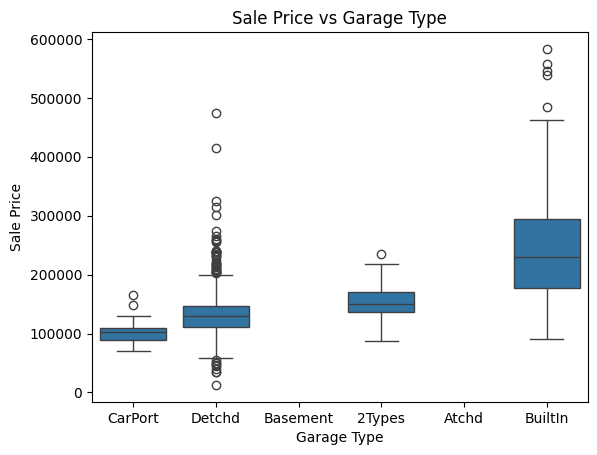

In [59]:
order = ['CarPort', 'Detchd', 'Basement', '2Types', 'Atchd', 'BuiltIn']
sns.boxplot(x='Garage Type', y='SalePrice', data=clean_df, order=order)
plt.xlabel('Garage Type')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Garage Type')
plt.show()

For better compatibility to tree based models we will use one hot encoding for the Garage type feature.

In [60]:
garage_type_dummies = pd.get_dummies(df_copy['Garage Type'], prefix='GarageType', drop_first=False)
df_copy = pd.concat([df_copy, garage_type_dummies], axis=1)
df_copy.drop('Garage Type', axis=1, inplace=True)

In [61]:
garage_cols = [col for col in df_copy.columns if col.startswith('GarageType_')]

# Check rows where all dummy columns are 0
no_garage_rows = df_copy[garage_cols].sum(axis=1) == 0

# Count how many rows that is
print("Rows with all 0s in garage type columns:", no_garage_rows.sum())

df_copy.loc[no_garage_rows, garage_cols].head()


Rows with all 0s in garage type columns: 157


,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
27,False,False,False,False,False,False
119,False,False,False,False,False,False
125,False,False,False,False,False,False
129,False,False,False,False,False,False
130,False,False,False,False,False,False


We cheked if NaN values where handled correctly, we have 157 rows with full 0 values => succes.

The next step is converting the construction year of the garage to the age of the garage for the year it was sold in and replacing missing values with maxInt(worst case for when a garage does not exist).

In [62]:
df_copy['Garage_Age'] = df_copy['Yr Sold'] - df_copy['Garage Yr Blt']
df_copy['Garage_Age'] = df_copy['Garage_Age'].fillna(df_copy['Garage_Age'].max() + 1)
df_copy.drop('Garage Yr Blt', axis=1, inplace=True)

In [63]:
print(df_copy['Garage_Age'].describe())
print(df_copy['Garage_Age'].isna().sum())

count    2929.000000
mean       34.282008
std        31.504321
min      -200.000000
25%         7.000000
50%        30.000000
75%        51.000000
max       115.000000
Name: Garage_Age, dtype: float64
0


In [64]:
df_copy[df_copy['Garage_Age'] < 0]['Garage_Age'].head(10)

,Garage_Age
2180,-1.0
2260,-200.0


In [65]:

mask = df_copy['Garage_Age'] < 0



In [66]:
# Align mask to clean_df
aligned_mask = mask.reindex(clean_df.index, fill_value=False)

# Now use it safely
cols = ['Garage Yr Blt', 'Garage Type', 'Garage Finish', 'Garage Qual',
        'Garage Cond', 'Garage Cars', 'Garage Area', 'Yr Sold']

print(clean_df.loc[aligned_mask, cols])



      Garage Yr Blt Garage Type Garage Finish Garage Qual Garage Cond  \
2180         2008.0      Attchd           Fin          TA          TA   
2260         2207.0      Attchd           RFn          TA          TA   

      Garage Cars  Garage Area  Yr Sold  
2180          3.0       1154.0     2007  
2260          2.0        502.0     2007  


These 2 rows are corrupted so we will remove them from our df copy.

In [67]:
# Indices of bad rows
bad_idx = [2180, 2260]

df_copy = df_copy.drop(index=bad_idx)

print(f"Removed {len(bad_idx)} invalid rows. New shape: {df_copy.shape}")


Removed 2 invalid rows. New shape: (2927, 86)


In [68]:
print(df_copy['Garage_Age'].describe())

count    2927.000000
mean       34.374103
std        31.209101
min         0.000000
25%         7.000000
50%        30.000000
75%        51.000000
max       115.000000
Name: Garage_Age, dtype: float64


In [129]:
(df_copy['Garage_Age'] == 115).sum()



np.int64(159)

Now, Garage finish.

In [70]:
print(clean_df['Garage Finish'].value_counts(dropna=False))
clean_df.groupby('Garage Finish')['SalePrice'].mean().sort_values()

Garage Finish
Unf    1231
RFn     812
Fin     728
NaN     159
Name: count, dtype: int64


,SalePrice
Garage Finish,
Unf,141209.013810
RFn,202619.366995
Fin,239820.456044


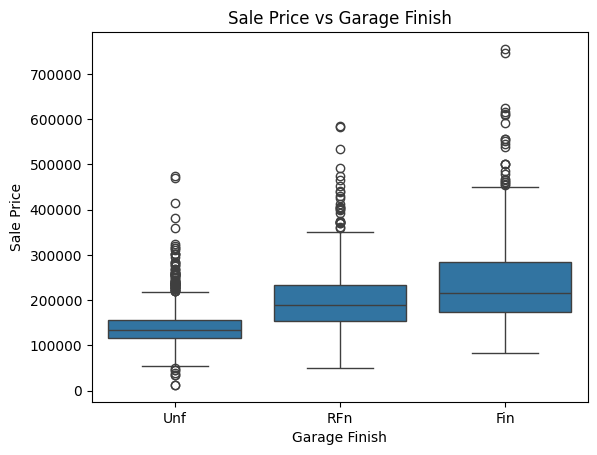

In [71]:
order = ['Unf', 'RFn', 'Fin']
sns.boxplot(x='Garage Finish', y='SalePrice', data=clean_df, order=order)
plt.xlabel('Garage Finish')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Garage Finish')
plt.show()

As there is a clear ordinal relationship between the finish categories. We will be mapping these to consecutive integers in our copy df.

In [72]:
garage_finish_map = {
    'NoGarage': 0,
    'Unf': 1,
    'RFn': 2,
    'Fin': 3
}
df_copy['GarageFinish_encoded'] = df_copy['Garage Finish'].fillna('NoGarage').map(garage_finish_map)

In [73]:
print(df_copy['GarageFinish_encoded'].value_counts(dropna=False))

GarageFinish_encoded
1    1230
2     811
3     727
0     159
Name: count, dtype: int64


In [74]:
df_copy.drop('Garage Finish', axis=1, inplace=True)

# Sanity check
print('Garage Finish' in df_copy.columns)

False


In [75]:
print(clean_df['Garage Cond'].value_counts(dropna=False))
clean_df.groupby('Garage Cond')['SalePrice'].mean().sort_values()

Garage Cond
TA     2665
NaN     159
Fa       74
Gd       15
Po       14
Ex        3
Name: count, dtype: int64


,SalePrice
Garage Cond,
Po,94850.000000
Fa,107492.351351
Ex,125000.000000
TA,187758.465291
Gd,194058.000000


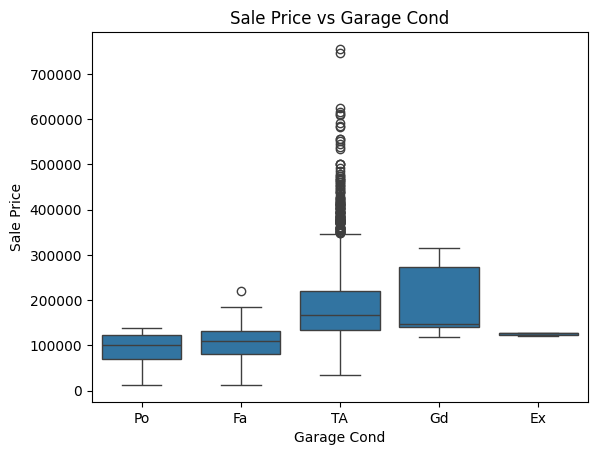

In [76]:
order = ['Po', 'Fa' ,'TA', 'Gd', 'Ex']
sns.boxplot(x='Garage Cond', y='SalePrice', data=clean_df, order=order)
plt.xlabel('Garage Cond')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Garage Cond')
plt.show()

Even though the relation is not fully consistent, we can attribute that to the small sample size for some cathegories, thus we will map them to integers.

In [77]:
garage_cond_mapping = {
    'Po': 1,
    'Fa': 2,
    'TA': 3,
    'Gd': 4,
    'Ex': 5,
    np.nan: 0
}

df_copy['Garage_Cond'] = df_copy['Garage Cond'].map(garage_cond_mapping)

In [78]:
print(df_copy['Garage_Cond'].value_counts(dropna=False))

Garage_Cond
3    2663
0     159
2      73
4      15
1      14
5       3
Name: count, dtype: int64


In [79]:
df_copy.drop('Garage Cond', axis=1, inplace=True)

Now lastly Garage Qual.

In [80]:
print(clean_df['Garage Qual'].value_counts(dropna=False))
clean_df.groupby('Garage Qual')['SalePrice'].mean().sort_values()

Garage Qual
TA     2615
NaN     159
Fa      124
Gd       24
Po        5
Ex        3
Name: count, dtype: int64


,SalePrice
Garage Qual,
Po,88880.000000
Fa,117816.822581
TA,187884.241300
Ex,241000.000000
Gd,243772.375000


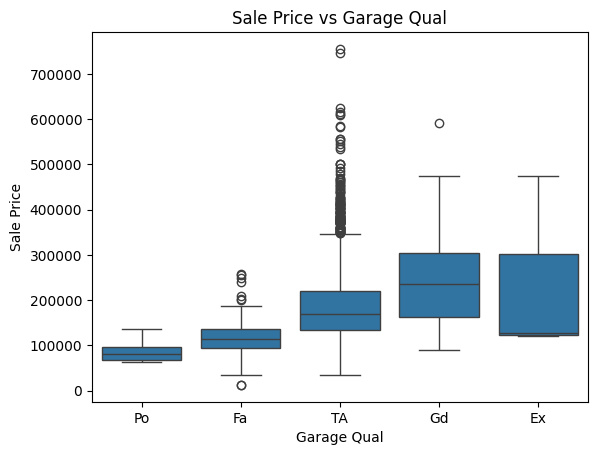

In [81]:
order = ['Po', 'Fa' ,'TA', 'Gd', 'Ex']
sns.boxplot(x='Garage Qual', y='SalePrice', data=clean_df, order=order)
plt.xlabel('Garage Qual')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Garage Qual')
plt.show()

As for the previous features we will be mapping the values.

In [82]:
garage_qual_mapping = {
    'Po': 1,
    'Fa': 2,
    'TA': 3,
    'Gd': 4,
    'Ex': 5,
    np.nan: 0
}

df_copy['Garage_Qual'] = df_copy['Garage Qual'].map(garage_qual_mapping)

In [83]:
print(df_copy['Garage_Qual'].value_counts(dropna=False))

Garage_Qual
3    2612
0     159
2     124
4      24
1       5
5       3
Name: count, dtype: int64


In [84]:
df_copy.drop('Garage Qual', axis=1, inplace=True)

In [85]:
print(clean_df['Garage Area'].describe())
print(clean_df['Garage Area'].isna().sum())

count    2929.000000
mean      472.819734
std       215.046549
min         0.000000
25%       320.000000
50%       480.000000
75%       576.000000
max      1488.000000
Name: Garage Area, dtype: float64
1


In [86]:
print(clean_df['Garage Cars'].describe())
print(clean_df['Garage Cars'].isna().sum())

count    2929.000000
mean        1.766815
std         0.760566
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: Garage Cars, dtype: float64
1


In [87]:
garage_cols = [col for col in df_copy.columns if 'Garage' in col]
df_copy.loc[df_copy['Garage Cars'].isna(), garage_cols]
df_copy.loc[df_copy['Garage Area'].isna(), garage_cols]


,Garage Cars,Garage Area,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,Garage_Age,GarageFinish_encoded,Garage_Cond,Garage_Qual
2236,NaN,NaN,False,False,False,False,False,True,115.0,0,0,0


We will be replacing these 2 values with the median for their coresponding type and age.

In [88]:
mask = (df_copy['GarageType_Detchd'] == True) & (df_copy['Garage_Age'] >= 110)

median_cars = df_copy.loc[mask, 'Garage Cars'].median()
median_area = df_copy.loc[mask, 'Garage Area'].median()

print(median_area, median_cars)

330.0 1.0


In [89]:
df_copy.loc[df_copy['Garage Cars'].isna(), 'Garage Cars'] = median_cars
df_copy.loc[df_copy['Garage Area'].isna(), 'Garage Area'] = median_area

print(df_copy['Garage Cars'].isna().sum())
print(df_copy['Garage Area'].isna().sum())


0
0


In [90]:
garage_cols = ['GarageFinish_encoded', 'Garage_Cond', 'Garage_Qual', 'Garage Cars', 'Garage Area']

no_garage_rows = df_copy[garage_cols].sum(axis=1) == 0
no_garage_count = no_garage_rows.sum()
print(f"Rows with no garage (all zeros): {no_garage_count}")

Rows with no garage (all zeros): 157


In [91]:
missing = df_copy.isna().sum().sort_values(ascending=False).head(12)
print(missing)

Bsmt Exposure     83
BsmtFin Type 2    81
BsmtFin Type 1    80
Bsmt Qual         80
Bsmt Cond         80
Bsmt Half Bath     2
Bsmt Full Bath     2
Bsmt Unf SF        1
Electrical         1
Total Bsmt SF      1
BsmtFin SF 2       1
BsmtFin SF 1       1
dtype: int64


In [92]:
for col in clean_df.columns:
    if 'Bsmt' in col:
        print(clean_df[col].value_counts(dropna=False))

Bsmt Qual
TA     1283
Gd     1219
Ex      258
Fa       88
NaN      80
Po        2
Name: count, dtype: int64
Bsmt Cond
TA     2616
Gd      122
Fa      104
NaN      80
Po        5
Ex        3
Name: count, dtype: int64
Bsmt Exposure
No     1906
Av      418
Gd      284
Mn      239
NaN      83
Name: count, dtype: int64
BsmtFin Type 1
GLQ    859
Unf    851
ALQ    429
Rec    288
BLQ    269
LwQ    154
NaN     80
Name: count, dtype: int64
BsmtFin SF 1
0.0       930
24.0       27
16.0       14
300.0       9
288.0       8
         ... 
837.0       1
897.0       1
1243.0      1
1460.0      1
1136.0      1
Name: count, Length: 996, dtype: int64
BsmtFin Type 2
Unf    2499
Rec     106
LwQ      89
NaN      81
BLQ      68
ALQ      53
GLQ      34
Name: count, dtype: int64
BsmtFin SF 2
0.0      2578
180.0       5
294.0       5
182.0       3
168.0       3
         ... 
811.0       1
799.0       1
555.0       1
852.0       1
352.0       1
Name: count, Length: 275, dtype: int64
Bsmt Unf SF
0.0       244
384

In [93]:
basement_cols = [col for col in clean_df.columns if 'Bsmt' in col]

basement_cat_cols = [
    'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
    'BsmtFin Type 1', 'BsmtFin Type 2'
]

no_bsmt_rows = clean_df[basement_cat_cols].isna().all(axis=1)

print(f"Rows with no basement (all NaN in basement categorical features): {no_bsmt_rows.sum()}")
clean_df.loc[no_bsmt_rows, basement_cols]


Rows with no basement (all NaN in basement categorical features): 80


,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
83,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
154,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
206,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
243,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
273,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2739,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2744,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2879,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2892,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0


Based on this its safe to say that these 80 rows have no basement information on all relevant columns => no basement.

In [94]:
print(clean_df['Total Bsmt SF'].value_counts(dropna=False))
print(clean_df['Total Bsmt SF'].isna().sum())

Total Bsmt SF
0.0       79
864.0     74
672.0     29
912.0     26
1040.0    25
          ..
815.0      1
993.0      1
485.0      1
2171.0     1
1210.0     1
Name: count, Length: 1059, dtype: int64
1


In [95]:
bsmt_sf_cols = ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']
missing_sf_rows = df_copy[bsmt_sf_cols].isna().any(axis=1)

df_copy.loc[missing_sf_rows, basement_cat_cols + bsmt_sf_cols]


,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF
1341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So we have 79 distinct rows where the surface is 0 with NaN for the other features and one more row filled with NaN values. We can conclude that all these rows have missing basements so we will replace the NaN values with 0.

In [96]:
# Replace NaN with 0 for rows with no basement
df_copy.loc[no_bsmt_rows, basement_cat_cols] = 0
df_copy.loc[missing_sf_rows, bsmt_sf_cols] = 0

In [97]:
# List of all basement-related columns
basement_cols = [
    'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
    'BsmtFin Type 1', 'BsmtFin Type 2',
    'BsmtFin SF 1', 'BsmtFin SF 2',
    'Bsmt Unf SF', 'Total Bsmt SF'
]

# Identify rows that should represent "no basement"
no_bsmt_rows = df_copy[basement_cols].eq(0).all(axis=1)

# Count how many rows meet that condition
num_no_bsmt = no_bsmt_rows.sum()

print(f"Number of rows with all basement features = 0: {num_no_bsmt}")


Number of rows with all basement features = 0: 80


All 80 rows of code were handled as intended. Now for each cathegorical basement feature we must convert to numerical values.

In [98]:
print(clean_df['Bsmt Qual'].value_counts(dropna=False))

print(clean_df.groupby('Bsmt Qual')['SalePrice'].mean().sort_values())

Bsmt Qual
TA     1283
Gd     1219
Ex      258
Fa       88
NaN      80
Po        2
Name: count, dtype: int64
Bsmt Qual
Po     84950.000000
Fa    109635.238636
TA    139847.394388
Gd    201726.765381
Ex    333369.313953
Name: SalePrice, dtype: float64


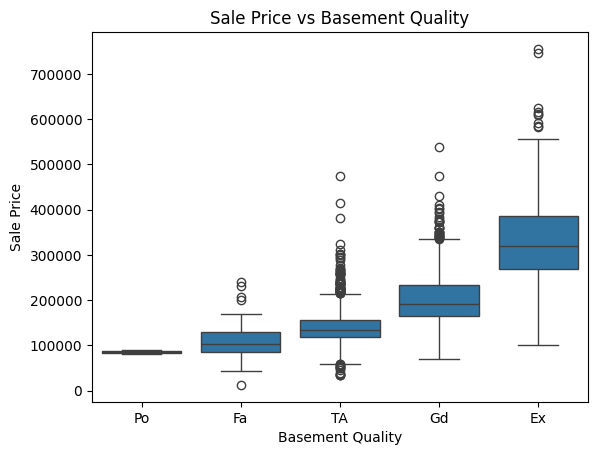

In [99]:
order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

sns.boxplot(x='Bsmt Qual', y='SalePrice', data=clean_df, order=order)
plt.xlabel('Basement Quality')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Basement Quality')
plt.show()

Clear relation to price.

In [100]:
bsmt_qual_mapping = {
    'Po': 1,
    'Fa': 2,
    'TA': 3,
    'Gd': 4,
    'Ex': 5,
    0: 0
}

df_copy['Bsmt_Qual'] = df_copy['Bsmt Qual'].map(bsmt_qual_mapping)

In [101]:
print(df_copy['Bsmt_Qual'].value_counts(dropna=False))

Bsmt_Qual
3    1282
4    1218
5     257
2      88
0      80
1       2
Name: count, dtype: int64


In [102]:
df_copy.drop('Bsmt Qual', axis=1, inplace=True)

Moving on with Bsmt Cond in the same way.

In [103]:
print(clean_df['Bsmt Cond'].value_counts(dropna=False))
print(clean_df.groupby('Bsmt Cond')['SalePrice'].mean().sort_values())


Bsmt Cond
TA     2616
Gd      122
Fa      104
NaN      80
Po        5
Ex        3
Name: count, dtype: int64
Bsmt Cond
Fa    123315.480769
Po    124063.200000
TA    183847.235092
Ex    195000.000000
Gd    214604.303279
Name: SalePrice, dtype: float64


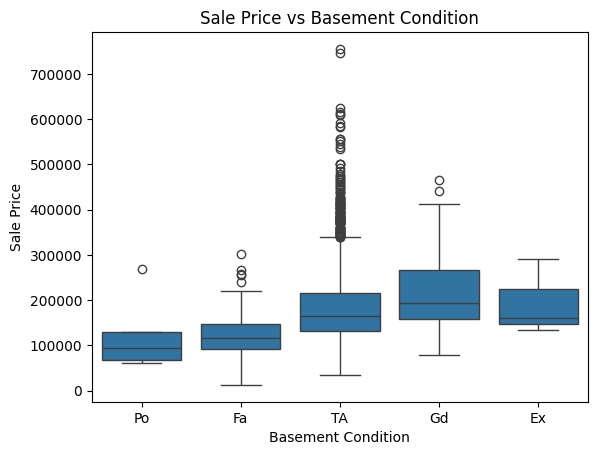

In [104]:
order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

sns.boxplot(x='Bsmt Cond', y='SalePrice', data=clean_df, order=order)
plt.xlabel('Basement Condition')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Basement Condition')
plt.show()

The avg for Ex condition is a bit lower than expected because of the small sample size.

In [105]:
bsmt_cond_mapping = {
    'Po': 1,
    'Fa': 2,
    'TA': 3,
    'Gd': 4,
    'Ex': 5,
    0: 0
}

df_copy['Bsmt_Cond'] = df_copy['Bsmt Cond'].map(bsmt_cond_mapping)

In [106]:
print(df_copy['Bsmt_Cond'].value_counts(dropna=False))

Bsmt_Cond
3    2613
4     122
2     104
0      80
1       5
5       3
Name: count, dtype: int64


In [107]:
df_copy.drop('Bsmt Cond', axis=1, inplace=True)

Next, Bsmt Exposure.

In [108]:
print(df_copy['Bsmt Exposure'].value_counts(dropna=False))
print(clean_df.groupby('Bsmt Exposure')['SalePrice'].mean().sort_values())

Bsmt Exposure
No     1905
Av      417
Gd      283
Mn      239
0        80
NaN       3
Name: count, dtype: int64
Bsmt Exposure
No    164229.815845
Mn    187559.100418
Av    207438.478469
Gd    267507.644366
Name: SalePrice, dtype: float64


In [109]:
df_copy.loc[df_copy['Bsmt Exposure'].isna(), [
    'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt Exposure',
    'BsmtFin Type 1', 'BsmtFin Type 2',
    'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'SalePrice'
]]

,Bsmt_Qual,Bsmt_Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,SalePrice
66,4,3,NaN,Unf,Unf,0.0,0.0,1595.0,1595.0,221500
1796,4,3,NaN,Unf,Unf,0.0,0.0,725.0,725.0,212109
2779,4,3,NaN,Unf,Unf,0.0,0.0,936.0,936.0,192500


We must handle these 3 rows carefuly as thy have basements but have missing exposure values, prob because of human error.

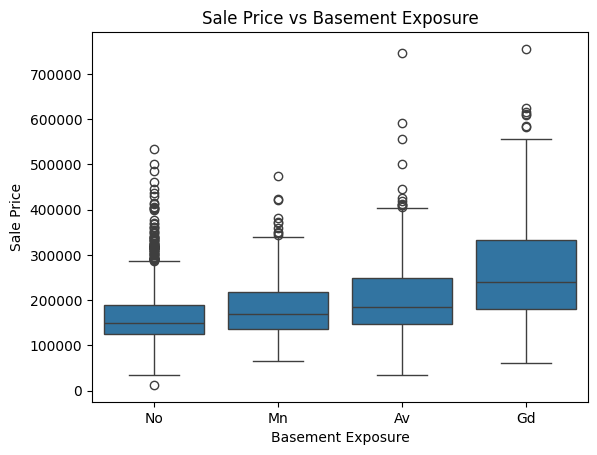

In [110]:
order = ['No', 'Mn', 'Av', 'Gd']

sns.boxplot(x='Bsmt Exposure', y='SalePrice', data=clean_df, order=order)
plt.xlabel('Basement Exposure')
plt.ylabel('Sale Price')
plt.title('Sale Price vs Basement Exposure')
plt.show()

In [111]:
bsmt_exposure_mapping = {
    'No': 1,
    'Mn': 2,
    'Av': 3,
    'Gd': 4,
    0: 0,
    np.nan: np.nan
}

df_copy['Bsmt_Exposure'] = df_copy['Bsmt Exposure'].map(bsmt_exposure_mapping)


In [112]:
print(df_copy['Bsmt_Exposure'].value_counts(dropna=False))

Bsmt_Exposure
1.0    1905
3.0     417
4.0     283
2.0     239
0.0      80
NaN       3
Name: count, dtype: int64


In [113]:
df_copy.drop('Bsmt Exposure', axis=1, inplace=True)

In [114]:
median_exposure = df_copy.loc[df_copy['Bsmt_Exposure'] > 0, 'Bsmt_Exposure'].median()
df_copy.loc[df_copy['Bsmt_Exposure'].isna(), 'Bsmt_Exposure'] = median_exposure


In [115]:
print(df_copy['Bsmt_Exposure'].value_counts(dropna=False))

Bsmt_Exposure
1.0    1908
3.0     417
4.0     283
2.0     239
0.0      80
Name: count, dtype: int64


We filled the 3 rows with the median.

In [116]:
missing = df_copy.isna().sum().sort_values(ascending=False).head(12)
print(missing)

Bsmt Half Bath    2
Bsmt Full Bath    2
Electrical        1
BsmtFin Type 2    1
MS SubClass       0
MS Zoning         0
Utilities         0
Lot Config        0
Land Slope        0
Neighborhood      0
Condition 1       0
Condition 2       0
dtype: int64


In [117]:
# Identify non-numeric columns
non_numeric_cols = df_copy.select_dtypes(exclude=np.number).columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index(['MS Zoning', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Exter Qual', 'Exter Cond', 'Foundation',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Paved Drive', 'Sale Type', 'Sale Condition', 'GarageType_2Types',
       'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn',
       'GarageType_CarPort', 'GarageType_Detchd'],
      dtype='object')


In [118]:
# drop non-numeric columns before calculating the correlation matrix
df_numeric = df_copy.select_dtypes(include=np.number)
correlation_matrix = df_numeric.corr()
correlation_matrix

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Paved_Street,Fence_Quality,MasVnr_Quality,Garage_Age,GarageFinish_encoded,Garage_Cond,Garage_Qual,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure
MS SubClass,1.000000,-0.402974,-0.203639,0.040304,-0.068439,0.037216,0.043790,0.005551,-0.057723,-0.071143,...,0.002396,-0.087059,0.003584,-0.003001,-0.030400,-0.110667,-0.093441,0.066688,-0.008977,0.066730
Lot Frontage,-0.402974,1.000000,0.385914,0.203765,-0.055675,0.121991,0.087359,0.216693,0.206266,0.055101,...,-0.047090,0.013063,0.171463,-0.119658,0.199880,0.112117,0.121084,0.107570,0.007279,0.159166
Lot Area,-0.203639,0.385914,1.000000,0.095424,-0.032541,0.022161,0.021201,0.118745,0.183749,0.084042,...,-0.134521,-0.029697,0.049730,-0.039130,0.110633,0.075627,0.084827,0.056725,0.004188,0.182270
Overall Qual,0.040304,0.203765,0.095424,1.000000,-0.095553,0.596667,0.568929,0.421417,0.280872,-0.040941,...,0.072584,-0.176600,0.424350,-0.583556,0.553608,0.289859,0.300392,0.641400,0.273559,0.354059
Overall Cond,-0.068439,-0.055675,-0.032541,-0.095553,1.000000,-0.369185,0.047274,-0.132092,-0.049874,0.040701,...,0.018160,0.178632,-0.160581,0.223569,-0.174803,0.045993,0.022338,-0.178660,0.108214,-0.076084
Year Built,0.037216,0.121991,0.022161,0.596667,-0.369185,1.000000,0.611751,0.306741,0.279922,-0.027140,...,0.062240,-0.215624,0.416858,-0.760289,0.593962,0.278259,0.297943,0.618834,0.190327,0.316683
Year Remod/Add,0.043790,0.087359,0.021201,0.568929,0.047274,0.611751,1.000000,0.191050,0.150969,-0.061861,...,0.080533,-0.177667,0.257077,-0.564285,0.445366,0.148598,0.162975,0.525744,0.185730,0.236631
Mas Vnr Area,0.005551,0.216693,0.118745,0.421417,-0.132092,0.306741,0.191050,1.000000,0.288079,-0.014426,...,0.022312,-0.097315,0.670719,-0.264669,0.274709,0.130890,0.143443,0.297101,0.090008,0.217561
BsmtFin SF 1,-0.057723,0.206266,0.183749,0.280872,-0.049874,0.279922,0.150969,0.288079,1.000000,-0.053698,...,0.016780,-0.004617,0.273008,-0.220707,0.260494,0.146433,0.162691,0.338187,0.183415,0.399215
BsmtFin SF 2,-0.071143,0.055101,0.084042,-0.040941,0.040701,-0.027140,-0.061861,-0.014426,-0.053698,1.000000,...,-0.008277,0.093286,-0.024229,0.020909,0.010575,0.060557,0.064526,-0.011784,0.080498,0.104208


In [119]:
linear_correlated_features = [
    (col1, col2, correlation_matrix.loc[col1, col2])
    for col1 in correlation_matrix.columns
    for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.8
]

linear_correlated_features

[('Overall Qual', 'SalePrice', np.float64(0.8000621487333915)),
 ('Gr Liv Area', 'TotRms AbvGrd', np.float64(0.8056574101402901)),
 ('TotRms AbvGrd', 'Gr Liv Area', np.float64(0.8056574101402901)),
 ('Fireplaces', 'FireplaceQu_None', np.float64(-0.8984878523275397)),
 ('Garage Cars', 'Garage Area', np.float64(0.8899684322542696)),
 ('Garage Area', 'Garage Cars', np.float64(0.8899684322542696)),
 ('SalePrice', 'Overall Qual', np.float64(0.8000621487333915)),
 ('FireplaceQu_None', 'Fireplaces', np.float64(-0.8984878523275397)),
 ('Garage_Cond', 'Garage_Qual', np.float64(0.9469983007389792)),
 ('Garage_Qual', 'Garage_Cond', np.float64(0.9469983007389792))]

In [120]:
df_copy[['Garage Area', 'Garage Cars']]

,Garage Area,Garage Cars
0,528.0,2.0
1,730.0,1.0
2,312.0,1.0
3,522.0,2.0
4,482.0,2.0
...,...,...
2925,588.0,2.0
2926,484.0,2.0
2927,0.0,0.0
2928,418.0,2.0


In [121]:
'''

!!! Features pairs like Garage_Qual + Garage_Cond need to be dropped, because their are not conclusive, i.e. describe the same thing, or duplicates
  Garage Area = Size of garage in square feet, Garage Cars = Size of garage in car capacity
  => feature pair is not conclusive for the linear relationship
'''

'\n\n!!! Features pairs like Garage_Qual + Garage_Cond need to be dropped, because their are not conclusive, i.e. describe the same thing, or duplicates\n  Garage Area = Size of garage in square feet, Garage Cars = Size of garage in car capacity \n  => feature pair is not conclusive for the linear relationship\n'

In [122]:
features_to_remove = [
    ('Gr Liv Area', 'TotRms AbvGrd', correlation_matrix.loc['Gr Liv Area', 'TotRms AbvGrd']),
    ('Garage Area', 'Garage Cars', correlation_matrix.loc['Garage Area', 'Garage Cars']),
    ('Garage_Cond', 'Garage_Qual', correlation_matrix.loc['Garage_Cond', 'Garage_Qual']),
    ('Garage_Qual', 'Garage_Cond', correlation_matrix.loc['Garage_Qual', 'Garage_Cond']),
    ('Fireplaces', 'FireplaceQu_None', correlation_matrix.loc['Fireplaces', 'FireplaceQu_None']),
    ('FireplaceQu_None', 'Fireplaces', correlation_matrix.loc['FireplaceQu_None', 'Fireplaces']),
    ('SalePrice', 'Overall Qual', correlation_matrix.loc['SalePrice', 'Overall Qual']),
    ('Garage Cars', 'Garage Area', correlation_matrix.loc['Garage Cars', 'Garage Area'])
]

# create new list excluding the features to remove
linear_correlated_features = [
    feature for feature in linear_correlated_features
    if feature not in features_to_remove
]

linear_correlated_features

[('Overall Qual', 'SalePrice', np.float64(0.8000621487333915)),
 ('TotRms AbvGrd', 'Gr Liv Area', np.float64(0.8056574101402901))]

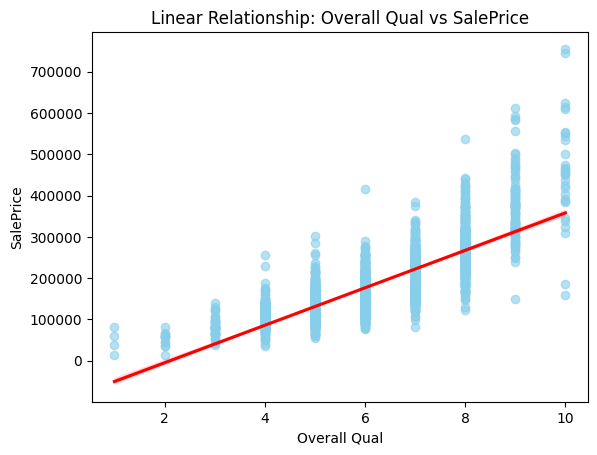

R² for Overall Qual vs SalePrice = 0.6400994418358884


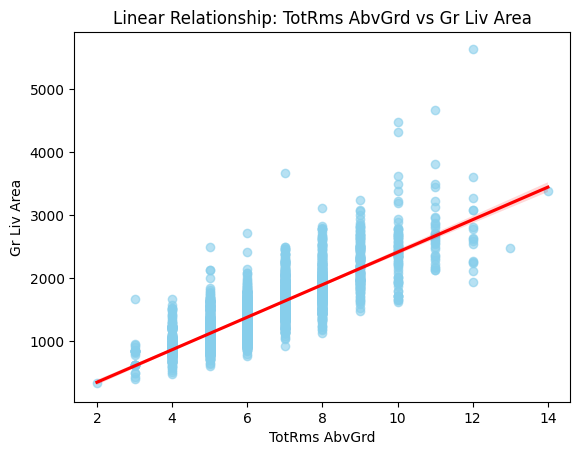

R² for TotRms AbvGrd vs Gr Liv Area = 0.6490838625139616


In [128]:
r_scores = {}

for col1, col2, corr_value in linear_correlated_features:
  X = np.array(df_numeric[f'{col1}']).reshape(-1, 1)
  y = df_numeric[f'{col2}']

  model = LinearRegression().fit(X, y)

  sns.regplot(
      x=f'{col1}',
      y=f'{col2}',
      data=df_numeric,
      scatter_kws={'alpha':0.6, 'color': 'skyblue'},
      line_kws={'color': 'red'}
  )
  plt.title(f'Linear Relationship: {col1} vs {col2}')
  plt.xlabel(f'{col1}')
  plt.ylabel(f'{col2}')
  plt.show()
  print(f"R² for {col1} vs {col2} =", model.score(X, y))
  r_scores[(col1, col2)] = model.score(X, y)


$$R^2 = 1 - \frac{SS_{\text{res}}}{SS_{\text{tot}}}$$

where:

$$SS_{\text{res}} = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$
$$SS_{\text{tot}} = \sum_{i=1}^{n}(y_i - \bar{y})^2$$
-> total variation in the data

In [124]:
r_scores

{('Overall Qual', 'SalePrice'): 0.6400994418358884,
 ('TotRms AbvGrd', 'Gr Liv Area'): 0.6490838625139616}

In [125]:
best_r_score = max(r_scores.values())
best_r_score

0.6490838625139616

In [126]:
'''

=> the 2 best liniarly correlated features are TotRms AbvGrd and Gr Liv Area

'''


'\n\n=> the 2 best liniarly correlated features are TotRms AbvGrd and Gr Liv Area\n\n'